<a href="https://colab.research.google.com/github/VincentStimper/normalizing-flows/blob/master/examples/real_nvp_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
print(device)

cuda


This is our target distribution.

In [3]:
!pip install h5py

In [19]:
from torch.utils.data import Dataset
import h5py
class TactileMaterialDataset(Dataset):
    def __init__(self, file_path, split='train', train_split=0.8):
        """
        Custom Dataset for loading and processing tactile material data.

        Args:
            file_path (str): Path to the HDF5 file.
            split (str): Dataset split, either 'train' or 'val'.
            train_split (float): Proportion of the dataset to use for training.
        """
        with h5py.File(file_path, 'r') as dataset:
            samples = dataset['samples'][:]  # Shape: [materials, samples, time_steps, taxels_x, taxels_y]
            materials = dataset['materials'][:]
            materials = [m.decode('utf-8') for m in materials]  # Decode material names if necessary

        # Set seed for reproducibility
        np.random.seed(42)

        # Shuffle samples within each class
        for i in range(samples.shape[0]):
            np.random.shuffle(samples[i])

        # Splits dataset into train and validation
        total_size = samples.shape[1]  # Number of samples per class
        train_size = int(train_split * total_size)

        # Generate indices for splitting
        indices = np.arange(total_size)
        np.random.shuffle(indices)
        train_indices = indices[:train_size]
        val_indices = indices[train_size:]

        if split == 'train':
            self.data = samples[:, train_indices, ...]  # Training samples
            self.labels = np.repeat(np.arange(samples.shape[0]), len(train_indices))  # Class labels
        elif split == 'val':
            self.data = samples[:, val_indices, ...]  # Validation samples
            self.labels = np.repeat(np.arange(samples.shape[0]), len(val_indices))
        else:
            raise ValueError("Invalid split value. Must be 'train' or 'val'.")

        # Flatten the taxels (4x4 -> 16) and reshape to [num_samples, time_steps, features]
        self.data = self.data.reshape((-1, samples.shape[2], 16))

        # Convert to PyTorch tensors
        self.data = torch.tensor(self.data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        self.labels = torch.tensor(self.labels, dtype=torch.long)

        # Debugging
        print(f"{split.capitalize()} dataset size: {len(self.data)}")
        assert len(self.data) == len(self.labels), "Data and labels length mismatch!"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = TactileMaterialDataset('tactmat.h5', split='train', train_split=0.8)
val_dataset = TactileMaterialDataset('tactmat.h5', split='val', train_split=0.8)

Train dataset size: 2880
Val dataset size: 720


In [24]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Pytorch-lightning

In [1]:
! pip install --quiet "torchmetrics >=1.0,<1.5" "numpy <3.0" "torchvision" "seaborn" "torch >=1.8.1,<2.5" "matplotlib" "tabulate" "pytorch-lightning >=2.0,<2.5"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import math
import os
import time
import urllib.request
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from IPython.display import HTML, display
from matplotlib.colors import to_rgb
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torch import Tensor
from torchvision import transforms

In [3]:
class ImageFlow(pl.LightningModule):
    def __init__(self, flows, import_samples=8):
        """ImageFlow.

        Args:
            flows: A list of flows (each a nn.Module) that should be applied on the images.
            import_samples: Number of importance samples to use during testing (see explanation below). Can be changed at any time

        """
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.import_samples = import_samples
        # Create prior distribution for final latent space
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        # Example input for visualizing the graph
        self.example_input_array = train_dataset.data[0][0].unsqueeze(dim=0)

    def forward(self, imgs):
        # The forward function is only used for visualizing the graph
        return self._get_likelihood(imgs)

    def encode(self, imgs):
        # Given a batch of images, return the latent representation z and ldj of the transformations
        z, ldj = imgs, torch.zeros(imgs.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, imgs, return_ll=False):
        """Given a batch of images, return the likelihood of those.

        If return_ll is True, this function returns the log likelihood of the input. Otherwise, the output metric is
        bits per dimension (scaled negative log likelihood)

        """
        z, ldj = self.encode(imgs)
        log_pz = self.prior.log_prob(z).sum(dim=[1, 2, 3])
        log_px = ldj + log_pz
        nll = -log_px
        # Calculating bits per dimension
        bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        return bpd.mean() if not return_ll else log_px

    @torch.no_grad()
    def sample(self, img_shape, z_init=None):
        """Sample a batch of images from the flow."""
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)

        # Transform z to x by inverting the flows
        ldj = torch.zeros(img_shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # An scheduler is optional, but can help in flows to get the last bpd improvement
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # Normalizing flows are trained by maximum likelihood => return bpd
        loss = self._get_likelihood(batch[0])
        self.log("train_bpd", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_likelihood(batch[0])
        self.log("val_bpd", loss)

    def test_step(self, batch, batch_idx):
        # Perform importance sampling during testing => estimate likelihood M times for each image
        samples = []
        for _ in range(self.import_samples):
            img_ll = self._get_likelihood(batch[0], return_ll=True)
            samples.append(img_ll)
        img_ll = torch.stack(samples, dim=-1)

        # To average the probabilities, we need to go from log-space to exp, and back to log.
        # Logsumexp provides us a stable implementation for this
        img_ll = torch.logsumexp(img_ll, dim=-1) - np.log(self.import_samples)

        # Calculate final bpd
        bpd = -img_ll * np.log2(np.exp(1)) / np.prod(batch[0].shape[1:])
        bpd = bpd.mean()

        self.log("test_bpd", bpd)

In [4]:
class Dequantization(nn.Module):
    def __init__(self, alpha=1e-5, quants=155):
        """Dequantization.

        Args:
            alpha: small constant that is used to scale the original input.
                    Prevents dealing with values very close to 0 and 1 when inverting the sigmoid
            quants: Number of possible discrete values (usually 256 for 8-bit image)

        """
        super().__init__()
        self.alpha = alpha
        self.quants = quants

    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = torch.floor(z).clamp(min=0, max=self.quants - 1).to(torch.int32)
        return z, ldj

    def sigmoid(self, z, ldj, reverse=False):
        # Applies an invertible sigmoid transformation
        if not reverse:
            ldj += (-z - 2 * F.softplus(-z)).sum(dim=list(range(1, z.ndim)))
            z = torch.sigmoid(z)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha  # Scale to prevent boundaries 0 and 1
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1 - z)).sum(dim=list(range(1, z.ndim)))
            z = torch.log(z) - torch.log(1 - z)
        return z, ldj

    def dequant(self, z, ldj):
        # Transform discrete values to continuous volumes
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj

In [184]:
train_dataset.data[0][0].unsqueeze(dim=0).shape

torch.Size([1, 1000, 16])

In [185]:
# Testing invertibility of dequantization layer
pl.seed_everything(42)
orig_img = train_dataset.data[0][0].unsqueeze(dim=0).unsqueeze(dim=0)
ldj = torch.zeros(
    1,
)
dequant_module = Dequantization()
deq_img, ldj = dequant_module(orig_img, ldj, reverse=False)
reconst_img, ldj = dequant_module(deq_img, ldj, reverse=True)

d1, d2 = torch.where(orig_img.squeeze() != reconst_img.squeeze())
if len(d1) != 0:
    print("Dequantization was not invertible.")
    for i in range(d1.shape[0]):
        print("Original value:", orig_img[0, 0, d1[i], d2[i]].item())
        print("Reconstructed value:", reconst_img[0, 0, d1[i], d2[i]].item())
else:
    print("Successfully inverted dequantization")

# Layer is not strictly invertible due to float precision constraints
# assert (orig_img == reconst_img).all().item()

INFO:lightning_fabric.utilities.seed:Seed set to 42


Dequantization was not invertible.
Original value: 0.0
Reconstructed value: 1
Original value: 17.0
Reconstructed value: 18
Original value: 0.0
Reconstructed value: 1
Original value: 8.0
Reconstructed value: 9
Original value: 0.0
Reconstructed value: 1
Original value: 3.0
Reconstructed value: 4
Original value: 14.0
Reconstructed value: 15
Original value: 10.0
Reconstructed value: 11
Original value: 0.0
Reconstructed value: 1


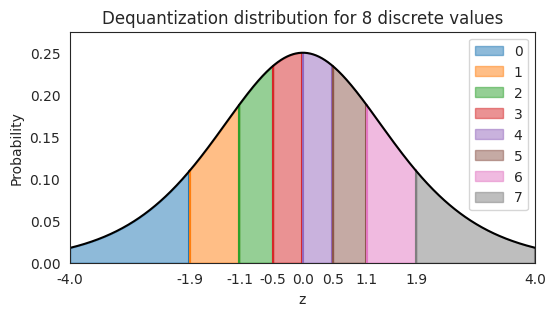

In [5]:
def visualize_dequantization(quants, prior=None):
    """Function for visualizing the dequantization values of discrete values in continuous space."""
    # Prior over discrete values. If not given, a uniform is assumed
    if prior is None:
        prior = np.ones(quants, dtype=np.float32) / quants
    prior = prior / prior.sum()  # Ensure proper categorical distribution

    inp = torch.arange(-4, 4, 0.01).view(-1, 1, 1, 1)  # Possible continuous values we want to consider
    ldj = torch.zeros(inp.shape[0])
    dequant_module = Dequantization(quants=quants)
    # Invert dequantization on continuous values to find corresponding discrete value
    out, ldj = dequant_module.forward(inp, ldj, reverse=True)
    inp, out, prob = inp.squeeze().numpy(), out.squeeze().numpy(), ldj.exp().numpy()
    prob = prob * prior[out]  # Probability scaled by categorical prior

    # Plot volumes and continuous distribution
    sns.set_style("white")
    _ = plt.figure(figsize=(6, 3))
    x_ticks = []
    for v in np.unique(out):
        indices = np.where(out == v)
        color = to_rgb("C%i" % v)
        plt.fill_between(inp[indices], prob[indices], np.zeros(indices[0].shape[0]), color=color + (0.5,), label=str(v))
        plt.plot([inp[indices[0][0]]] * 2, [0, prob[indices[0][0]]], color=color)
        plt.plot([inp[indices[0][-1]]] * 2, [0, prob[indices[0][-1]]], color=color)
        x_ticks.append(inp[indices[0][0]])
    x_ticks.append(inp.max())
    plt.xticks(x_ticks, [f"{x:.1f}" for x in x_ticks])
    plt.plot(inp, prob, color=(0.0, 0.0, 0.0))
    # Set final plot properties
    plt.ylim(0, prob.max() * 1.1)
    plt.xlim(inp.min(), inp.max())
    plt.xlabel("z")
    plt.ylabel("Probability")
    plt.title("Dequantization distribution for %i discrete values" % quants)
    plt.legend()
    plt.show()
    plt.close()


visualize_dequantization(quants=8)

In [6]:
class VariationalDequantization(Dequantization):
    def __init__(self, var_flows, alpha=1e-5):
        """Variational Dequantization.

        Args:
            var_flows: A list of flow transformations to use for modeling q(u|x)
            alpha: Small constant, see Dequantization for details

        """
        super().__init__(alpha=alpha)
        self.flows = nn.ModuleList(var_flows)

    def dequant(self, z, ldj):
        z = z.to(torch.float32)
        img = (z / 154.0) * 2 - 1  # We condition the flows on x, i.e. the original image

        # Prior of u is a uniform distribution as before
        # As most flow transformations are defined on [-infinity,+infinity], we apply an inverse sigmoid first.
        deq_noise = torch.rand_like(z).detach()
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=True)
        for flow in self.flows:
            deq_noise, ldj = flow(deq_noise, ldj, reverse=False, orig_img=img)
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=False)

        # After the flows, apply u as in standard dequantization
        z = (z + deq_noise) / 155.0
        ldj -= np.log(155.0) * np.prod(z.shape[1:])
        return z, ldj

In [7]:
class CouplingLayer(nn.Module):
    def __init__(self, network, mask, c_in):
        """Coupling layer inside a normalizing flow.

        Args:
            network: A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask: Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in: Number of input channels

        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        # Register mask as buffer as it is a tensor which is not a parameter,
        # but should be part of the modules state.
        self.register_buffer("mask", mask)

    def forward(self, z, ldj, reverse=False, orig_img=None):
        """Forward.

        Args:
            z: Latent input to the flow
            ldj:
                The current ldj of the previous flows. The ldj of this layer will be added to this tensor.
            reverse: If True, we apply the inverse of the layer.
            orig_img:
                Only needed in VarDeq. Allows external input to condition the flow on (e.g. original image)

        """
        # Apply network to masked input
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)

        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac

        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1, 2, 3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1, 2, 3])

        return z, ldj

In [8]:
def create_checkerboard_mask(h, w, invert=False):
    x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
    xx, yy = torch.meshgrid(x, y)
    mask = torch.fmod(xx + yy, 2)
    mask = mask.to(torch.float32).view(1, 1, h, w)
    if invert:
        mask = 1 - mask
    return mask


def create_channel_mask(c_in, invert=False):
    mask = torch.cat([torch.ones(c_in // 2, dtype=torch.float32), torch.zeros(c_in - c_in // 2, dtype=torch.float32)])
    mask = mask.view(1, c_in, 1, 1)
    if invert:
        mask = 1 - mask
    return mask

In [9]:
class ConcatELU(nn.Module):
    """Activation function that applies ELU in both direction (inverted and plain).

    Allows non-linearity while providing strong gradients for any input (important for final convolution)

    """

    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)


class LayerNormChannels(nn.Module):
    def __init__(self, c_in, eps=1e-5):
        """This module applies layer norm across channels in an image.

        Args:
            c_in: Number of channels of the input
            eps: Small constant to stabilize std

        """
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.gamma + self.beta
        return y


class GatedConv(nn.Module):
    def __init__(self, c_in, c_hidden):
        """This module applies a two-layer convolutional ResNet block with input gate.

        Args:
            c_in: Number of channels of the input
            c_hidden: Number of hidden dimensions we want to model (usually similar to c_in)

        """
        super().__init__()
        self.net = nn.Sequential(
            ConcatELU(),
            nn.Conv2d(2 * c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            nn.Conv2d(2 * c_hidden, 2 * c_in, kernel_size=1),
        )

    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)


class GatedConvNet(nn.Module):
    def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=3):
        """Module that summarizes the previous blocks to a full convolutional neural network.

        Args:
            c_in: Number of input channels
            c_hidden: Number of hidden dimensions to use within the network
            c_out: Number of output channels. If -1, 2 times the input channels are used (affine coupling)
            num_layers: Number of gated ResNet blocks to apply

        """
        super().__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        layers = []
        layers += [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [GatedConv(c_hidden, c_hidden), LayerNormChannels(c_hidden)]
        layers += [ConcatELU(), nn.Conv2d(2 * c_hidden, c_out, kernel_size=3, padding=1)]
        self.nn = nn.Sequential(*layers)

        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()

    def forward(self, x):
        return self.nn(x)

In [10]:
def create_simple_flow(use_vardeq=True):
    flow_layers = []
    if use_vardeq:
        vardeq_layers = [
            CouplingLayer(
                network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                mask=create_checkerboard_mask(h=1000, w=16, invert=(i % 2 == 1)),
                c_in=1,
            )
            for i in range(4)
        ]
        flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
    else:
        flow_layers += [Dequantization()]

    for i in range(8):
        flow_layers += [
            CouplingLayer(
                network=GatedConvNet(c_in=1, c_hidden=32),
                mask=create_checkerboard_mask(h=1000, w=16, invert=(i % 2 == 1)),
                c_in=1,
            )
        ]

    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

In [11]:
def train_flow(flow, model_name="MNISTFlow"):
    # Create a PyTorch Lightning trainer
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=200,
        gradient_clip_val=1.0,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    train_data_loader = train_loader
    result = None

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join( model_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        ckpt = torch.load(pretrained_filename, map_location=device)
        flow.load_state_dict(ckpt["state_dict"])
        result = ckpt.get("result", None)
    else:
        print("Start training", model_name)
        trainer.fit(flow, train_data_loader, val_loader)

    # Test best model on validation and test set if no result has been found
    # Testing can be expensive due to the importance sampling.
    if result is None:
        val_result = trainer.test(flow, dataloaders=val_loader, verbose=False)
        start_time = time.time()
        # test_result = trainer.test(flow, dataloaders=test_loader, verbose=False)
        # duration = time.time() - start_time
        # result = {"test": test_result, "val": val_result, "time": duration / len(test_loader) / flow.import_samples}

    return flow, result

In [12]:
class SqueezeFlow(nn.Module):
    def forward(self, z, ldj, reverse=False):
        B, C, H, W = z.shape
        if not reverse:
            # Forward direction: H x W x C => H/2 x W/2 x 4C
            z = z.reshape(B, C, H // 2, 2, W // 2, 2)
            z = z.permute(0, 1, 3, 5, 2, 4)
            z = z.reshape(B, 4 * C, H // 2, W // 2)
        else:
            # Reverse direction: H/2 x W/2 x 4C => H x W x C
            z = z.reshape(B, C // 4, 2, 2, H, W)
            z = z.permute(0, 1, 4, 2, 5, 3)
            z = z.reshape(B, C // 4, H * 2, W * 2)
        return z, ldj

In [13]:
sq_flow = SqueezeFlow()
rand_img = torch.arange(1, 17).view(1, 1, 4, 4)
print("Image (before)\n", rand_img)
forward_img, _ = sq_flow(rand_img, ldj=None, reverse=False)
print("\nImage (forward)\n", forward_img.permute(0, 2, 3, 1))  # Permute for readability
reconst_img, _ = sq_flow(forward_img, ldj=None, reverse=True)
print("\nImage (reverse)\n", reconst_img)

Image (before)
 tensor([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [13, 14, 15, 16]]]])

Image (forward)
 tensor([[[[ 1,  2,  5,  6],
          [ 3,  4,  7,  8]],

         [[ 9, 10, 13, 14],
          [11, 12, 15, 16]]]])

Image (reverse)
 tensor([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [13, 14, 15, 16]]]])


In [14]:
class SplitFlow(nn.Module):
    def __init__(self):
        super().__init__()
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)

    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, z_split = z.chunk(2, dim=1)
            ldj += self.prior.log_prob(z_split).sum(dim=[1, 2, 3])
        else:
            z_split = self.prior.sample(sample_shape=z.shape).to(device)
            z = torch.cat([z, z_split], dim=1)
            ldj -= self.prior.log_prob(z_split).sum(dim=[1, 2, 3])
        return z, ldj

In [15]:
def create_multiscale_flow():
    flow_layers = []

    vardeq_layers = [
        CouplingLayer(
            network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
            mask=create_checkerboard_mask(h=1000, w=16, invert=(i % 2 == 1)),
            c_in=1,
        )
        for i in range(4)
    ]
    flow_layers += [VariationalDequantization(vardeq_layers)]

    flow_layers += [
        CouplingLayer(
            network=GatedConvNet(c_in=1, c_hidden=32),
            mask=create_checkerboard_mask(h=1000, w=16, invert=(i % 2 == 1)),
            c_in=1,
        )
        for i in range(2)
    ]
    flow_layers += [SqueezeFlow()]
    for i in range(2):
        flow_layers += [
            CouplingLayer(
                network=GatedConvNet(c_in=4, c_hidden=48), mask=create_channel_mask(c_in=4, invert=(i % 2 == 1)), c_in=4
            )
        ]
    flow_layers += [SplitFlow(), SqueezeFlow()]
    for i in range(4):
        flow_layers += [
            CouplingLayer(
                network=GatedConvNet(c_in=8, c_hidden=64), mask=create_channel_mask(c_in=8, invert=(i % 2 == 1)), c_in=8
            )
        ]

    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

In [25]:
def print_num_params(model):
    num_params = sum(np.prod(p.shape) for p in model.parameters())
    print(f"Number of parameters: {num_params:,}")


print_num_params(create_simple_flow(use_vardeq=False))
print_num_params(create_simple_flow(use_vardeq=True))
print_num_params(create_multiscale_flow())

Number of parameters: 556,312
Number of parameters: 628,388
Number of parameters: 1,711,818


In [26]:
flow_dict = {"simple": {}, "vardeq": {}, "multiscale": {}}
flow_dict["simple"]["model"], flow_dict["simple"]["result"] = train_flow(
    create_simple_flow(use_vardeq=False), model_name="MNISTFlow_simple"
)
flow_dict["vardeq"]["model"], flow_dict["vardeq"]["result"] = train_flow(
    create_simple_flow(use_vardeq=True), model_name="MNISTFlow_vardeq"
)
flow_dict["multiscale"]["model"], flow_dict["multiscale"]["result"] = train_flow(
    create_multiscale_flow(), model_name="MNISTFlow_multiscale"
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Start training MNISTFlow_simple


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode  | In sizes | Out sizes
--------------------------------------------------------------------
0 | flows | ModuleList | 556 K  | train | ?        | ?        
--------------------------------------------------------------------
556 K     Trainable params
0         Non-trainable params
556 K     Total params
2.225     Total estimated model params size (MB)
218       Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/pyt

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3595 has 14.73 GiB memory in use. Of the allocated memory 13.71 GiB is allocated by PyTorch, and 927.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)